In [18]:
%pip install opencv-python clip
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install matplotlib

# CLIP

CLIP - это модель OpenAI (https://openai.com/index/clip/) Они сделали ее уже достаточно давно (2021), но актуальности она не потеряла. Это стандартная модель для картиночно-текстовых эмбедингов. В каком-то смысле это BERT для мультимодальных моделей. 
В отличие от BERT здесь используется не self-supervised learning, где обучающие данные генерируются просто из существующих данных с помощью какой-то абстрактной задачи (заполнение пропусков и тп), а стандартное обучение с учителем, а сам подход называется constrastive learning. В чем-то это очень похоже на word2vec c negative sampling (если помните там задача в том, чтобы два вектора которые встречаются вместе в контексте были близки, а те что не встречаются были далеки друг от друга), но здесь нужны пары картинка-текст, которые нужно размечать. Тем не менее, OpenAI собрали 400млн таких пар в интернете! Сам процесс обучение здесь достаточно понятный - есть два енкодера, текстовый и картиночный; обучающая пара текст-картинка пропускается через эти энкодеры и на выходе получается два эмбединга и в процессе обучение максимизируется близость между текстовым и картиночным эмбедингами из одной пары (и минизизируется близость между эмбедингами из других пар в батче). В результате получается две модели энкодера, который переводят текст или картинку в одно пространство. Что с этим можно делать? Например, можно искать картинки по текстовому запросу (эмбедим запросов и сравниваем с эмбедингами картинок в базе) или делать zero-shot классификаторы для картинов, где мы сравниваем картинку с каким-то списком слов (==классов) и выбираем наиболее близкий.


![](https://images.ctfassets.net/kftzwdyauwt9/fbc4f633-9ad4-4dc2-3809c22df5e0/0bd2d5abf90d052731538613e4a42668/overview-a.svg)
![](https://images.ctfassets.net/kftzwdyauwt9/d9d46e4b-6d6a-4f9e-59a242ea1441/c7b386880f1af005fd02f159de7f4d00/overview-b.svg)

В то время OpenAI все еще делало действительно открытые модели. CLIP лежит в открытом доступе со свободной лицензией. Давайте его попробуем

In [4]:
from torchvision import transforms
# это вспомогательные функции чтобы картинки были поменьше
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

In [4]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

In [32]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [35]:
url = "https://images.ctfassets.net/440y9b545yd9/49v1AZmZdiPYkJ4A3vrayj/d7d7db21fed2ef30f5b8e3899633d292/Samoyed850.jpg"
image = Image.open(requests.get(url, stream=True).raw)

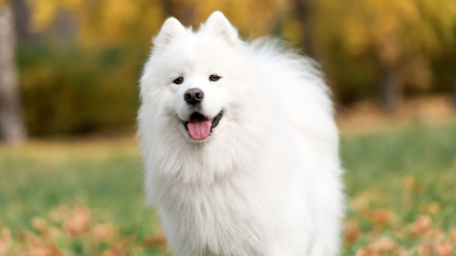

In [36]:
to_256(image)

Мы можем написать два текстовых описания и сравнить их с картинкой, чтобы на выходе получить как-бы вероятности классов (собака или кошка)

In [37]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [38]:
# вероятность собаки почти 100%
probs

tensor([[0.0017, 0.9983]], grad_fn=<SoftmaxBackward0>)

## SAM-CLIP

На картинке может быть много разных объектов и близость может размазаться между ними. Но можно воспользоваться еще одной открытой моделью - [SAM](https://github.com/facebookresearch/segment-anything) (segment almost anything, от Meta). Эта модель обучена детектировать все объекты на картинке и она возвращает маски и bounding box'ы отдельных объектов на картинке. Их можно вырезать и сравнить с текстом через clip.




In [ ]:
# скачаем модель
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import requests

In [2]:
m = build_sam(checkpoint="sam_vit_h_4b8939.pth", ).to('cuda')

In [5]:
mask_generator = SamAutomaticMaskGenerator(m)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
img_url = 'https://foldlandia.ru/wp-content/uploads/sobaka-i-koshka.png'
original_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image_array = np.array(original_image)

masks = mask_generator.generate(image_array)

In [7]:
# masks

In [8]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def segment_image(image_array: np.array, segmentation_mask):
    h, w, _ = image_array.shape
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", (w,h), (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image
# Cut out all masks

In [9]:
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image_array, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [10]:
@torch.no_grad()
def retriev(images: list[Image.Image], search_text: str) -> int:
    inputs = processor(text=search_text, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=0) # we can take the softmax to get the label probabilities
    return probs

def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [11]:
scores = retriev(cropped_boxes, "cat")
indices = get_indices_of_values_above_threshold(scores, 0.2)

In [13]:
indices

[1]

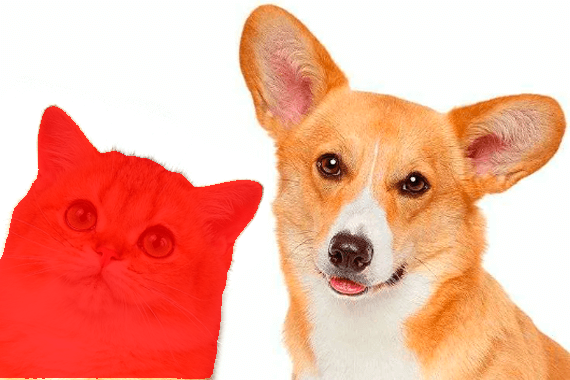

In [18]:
segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray((masks[seg_idx]["segmentation"]).astype('uint8')*255)
    segmentation_masks.append(segmentation_mask_image)


overlay_image = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
# мы определяем цвет и прозрачность чтобы подстветить этот объект
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image

# Blip

Clip переводит тексты и картинки в одно пространство и там с ними можно что-то делать. Но CLIP не может перейти от картинки в текст или из текста в картинку. Для этого есть отдельные модели. 

Для картинки в текст есть две хорошие опенсорсные модели - BLIP2 и Idefics.

Поверхностная архитектура BLIP2:
![](https://miro.medium.com/v2/resize:fit:1400/1*48hOmexceHGl5drITL6-AQ.jpeg)

Описание Flamingo (на которой построен Idefics):
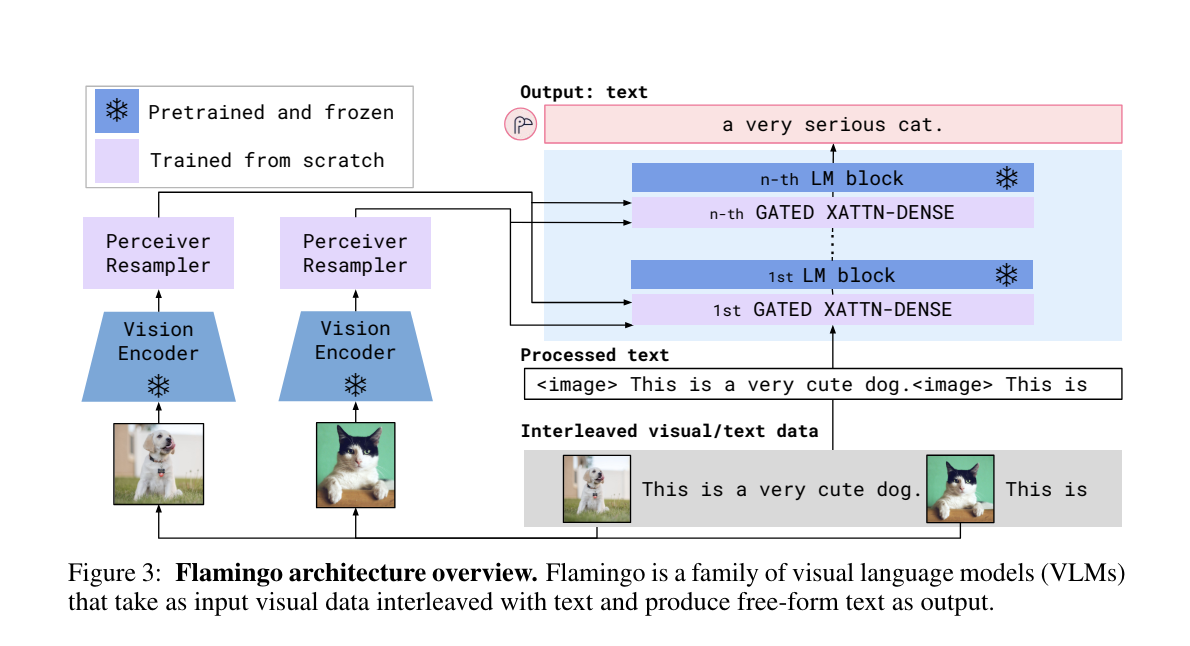

Выглядит достаточно сложно, но если присмотреться, то в обоих случаях это какой-то промежуточный обучаемый слой/слои которые соединяются предобученные LLM и картиночные энкодеры.

Давайте посмотрим на BLIP2

In [56]:
import requests
from PIL import Image
from transformers import BlipProcessor, Blip2ForConditionalGeneration

В названии можно увидеть модель flan-t5, так как blip2 не обучает llm с нуля, а использует готовую

In [57]:
processor = BlipProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [58]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

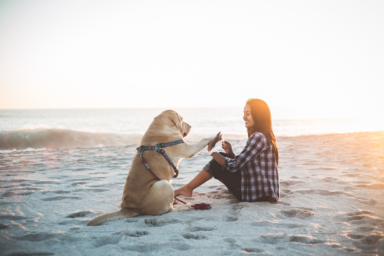

In [59]:
to_256(raw_image)

In [60]:
question = "describe the picture in great detail"
inputs = processor(raw_image, question, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


woman sitting on the beach with dog


### Idefics

Idefics более поздняя модель и в ней есть возможность использовать сразу несколько картинок! И она уже ближе по устройству к привичным чат моделям. 


In [1]:
from torchvision import transforms
# это вспомогательные функции чтобы картинки были поменьше
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda:0"

# Note that passing the image urls (instead of the actual pil images) to the processor is also possible
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
image3 = load_image("https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg")


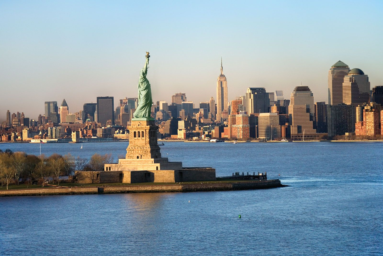

In [2]:
to_256(image1)

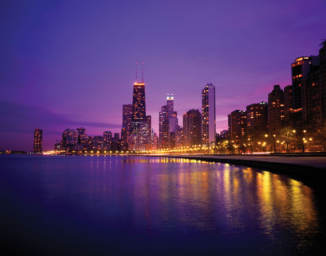

In [3]:
to_256(image2)

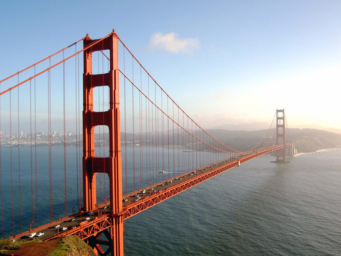

In [4]:
to_256(image3)

In [7]:
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", size= {"longest_edge": 448, "shortest_edge": 378})


from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/idefics2-8b", torch_dtype=torch.float16,quantization_config=quantization_config,
)
# .to(DEVICE)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [54]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What about this one?"},
        ]
    },       
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image3], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

In [55]:
# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500, )
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [56]:
print(generated_texts[0])

User: What do we see in this image? 
Assistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty. 
User: What about this one? 
Assistant: This is a picture of a bridge.


In [81]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            
            {"type": "image"},
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Describe the first image"},
            
        ]
    },       
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2, image3], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

In [82]:
# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500, do_sample=False)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [83]:
print(generated_texts[0])

User: Describe the first image 
Assistant: This image is taken outdoors. At the top of the image there is a sky. At the bottom of the image there is a river with water.


# Stable diffusion

Переход от текста к картинке тяжелее, но это более популярная задача. Есть много коммерческих продуктов, которые генерируют картинки по текстовому описанию (Midjourney, DALLE, Ideogram) и есть открытые и полуоткрытые модели, в первую очередь - stable diffusion. 

У stable diffusion сложная история. Изначально это ресерческий проект про Latent Diffusion Models (семейство моделей), который делали исследователи из Мюнхенского Университета - https://github.com/CompVis/latent-diffusion Но либо почти сразу, либо через какое-то время многие исследователи стали работать или получать финансирование в стартапе StabilityAI и он стало ассоциироваться с stable diffusion моделями. Версии 1.6, 2.0, SDXL и SD3 - разработаны StabilityAI. Но сейчас основной костяк изначальных разработчиков ушел из StabilityAI, а CEO уволили и вообще непонятно будут ли они дальше существовать. На качестве моделей это тоже сказалось, но других открытых моделей пока нет.

Stable diffusion состоит из 3 основных частей - текстового энкодера, Unet (диффузионной модели) и автоэнкодера. 

Unet: 

![](https://i.ibb.co/Lt2WkD2/image-42.png)  

Автоэнкодер:

![](https://i.ibb.co/z6sCbgQ/image-43.png)

А текстовый энкодер это CLIP из картинки выше.


![](https://i.ibb.co/Bjr08G1/image-44.png)

Вместе архитектура устроена как-то так:

![](https://i.ibb.co/mHj39FD/Screenshot-2024-05-16-at-21-11-51.png)



Все происходит в латентном пространстве (т.е. в пространстве эмбеддингов, а не пикселей). Эмбединги меньше картинок и они фиксированного размера, поэтому это эффективнее. Также это просто работает. Если вы послушаете интервью с ЛеКуном, то часто можно услышать как он говорит о том, что идея генерировать пиксили не работает, нужно генерировать эмбединги и потом переводить их в пиксели отдельно.

Генерация начинается со случайного шума (RNG) (который генерируется уже в эмбединг пространстве). Либо можно подать на вход исходную картинку, которая будет переведена в эмбединг пространство с помощью автоэнкодера (vae encoder). 
Входной текст (промпт) переводится в эмбединг с помощью text encoder. Дальше этот эмбединг будет использоваться, чтобы направлять процесс генерации. 
Сам процесс генерации происходит в Diffusion model. Unet модель предсказывает шум в изначальном эмбединге, на основе текстового эмбединга. 
Шум исключается из эмбединга в цикле понемногу (вначале убирается больше шума, в конце все меньше и меньше).  
Эмбединг, из которого удален шум, передается в автоэнкодер, чтобы вернуться в пространство пикселей (сгенерировать саму картинку).

Давайте посмотрим как можно использовать готовую модель генерации картинок

In [91]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline, StableDiffusionXLPipeline
from diffusers.utils import load_image
from PIL import Image
from torchvision import transforms
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

Давайте попробуем SDXL, а точнее дистилированную ее версию - https://huggingface.co/segmind/SSD-1B

In [92]:
pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [95]:
prompt = 'a cute cat'
# итоговый результат сильно зависит от случайного шума
# для воспроизводимости результатов можно зафиксировать seed и шум будет одинаковый 
# и итоговая картинка тоже будет одинаковая при разных запусках
generator = generator=torch.Generator('cuda').manual_seed(12363)

gen_image = pipe(prompt,
             generator=generator,
             height=768, # размер итоговой картинки
             width=1344, # размер итоговой картинки
             guidance_scale=9.0, # значимость текстового промпта в диффузии, можно увеличить чтобы было больше похоже на промпт
             num_inference_steps=20, # количество шагов диффузии, чем больше тем лучше, но и дольше; поздние шаги изменяют все меньше и меньше
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

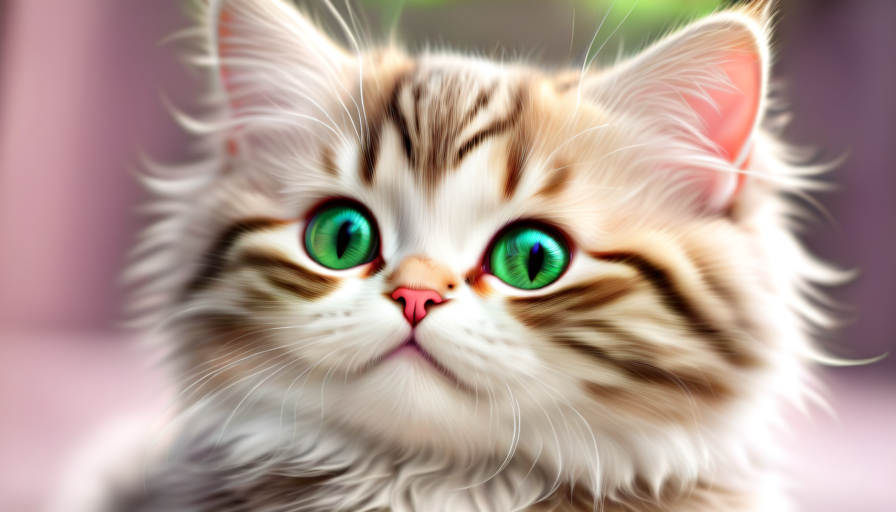

In [94]:
# seed 12362
to_512(gen_image)

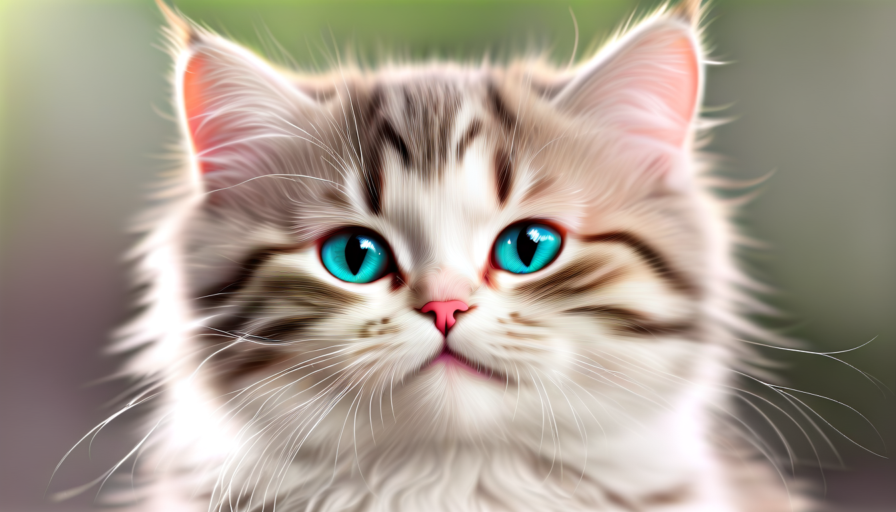

In [96]:
# seed 12363
to_512(gen_image)

Давайте попробуем начать не со случайного шума, а с какой-нибудь картинки

In [97]:
# для этого есть свой пайплайн, который состоит и тех же моделей
pipe_img2img = StableDiffusionXLImg2ImgPipeline(
            vae=pipe.vae,
            text_encoder=pipe.text_encoder,
            text_encoder_2=pipe.text_encoder_2,
            tokenizer=pipe.tokenizer,
            tokenizer_2=pipe.tokenizer_2,
            unet=pipe.unet,
            scheduler=pipe.scheduler,
        )

In [98]:
img_url = "https://images.unsplash.com/photo-1715646528665-2fb38daf27c6?q=80&w=3174&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
init_image = to_512(load_image(img_url).convert("RGB"))

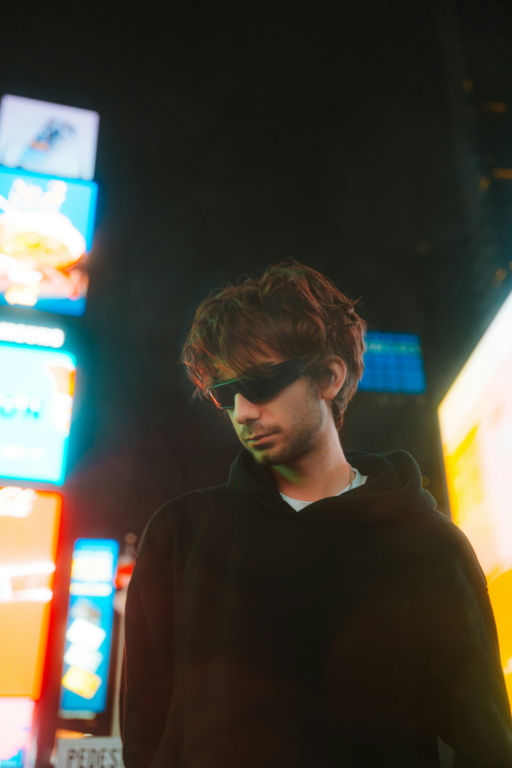

In [99]:
init_image

In [100]:
prompt = 'a cat in a hoodie'
generator = generator=torch.Generator('cuda').manual_seed(12363)


gen_image = pipe_img2img(prompt,
                         image=init_image, # подаем исходну картинку
                         generator=generator,
                         strength=0.2, # этот параметр регулирует силу изменения картинки (чем больше тем сильнее изменится)
                         guidance_scale=9.0,
                         num_inference_steps=20,
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

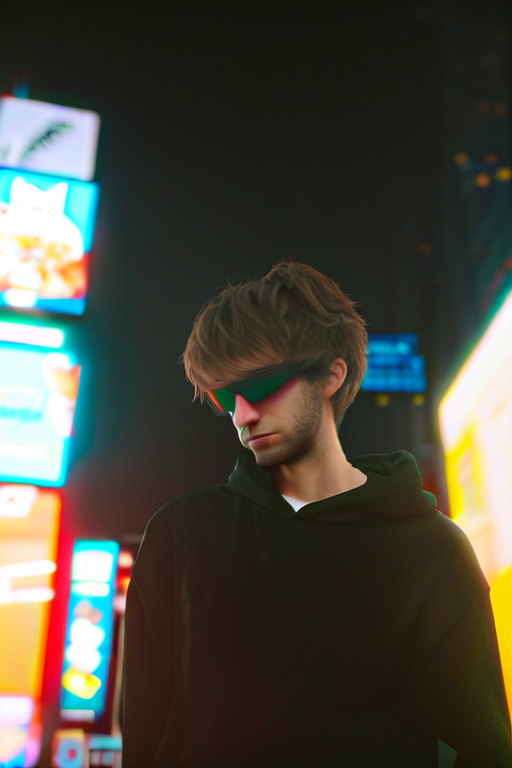

In [101]:
gen_image

Давайте переберем разные значение strength чтобы наглядно увидеть на что это влияет

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def image_grid(array, ncols=4):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, channels))
    
    return img_grid

In [103]:
images = []
for i in range(1, 10):
    generator = generator=torch.Generator('cuda').manual_seed(12363+i)


    images.append(np.array(pipe_img2img(prompt,
                             image=init_image,
                             generator=generator,
                             strength=i/10,
                             guidance_scale=9.0,
                             num_inference_steps=20).images[0]))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

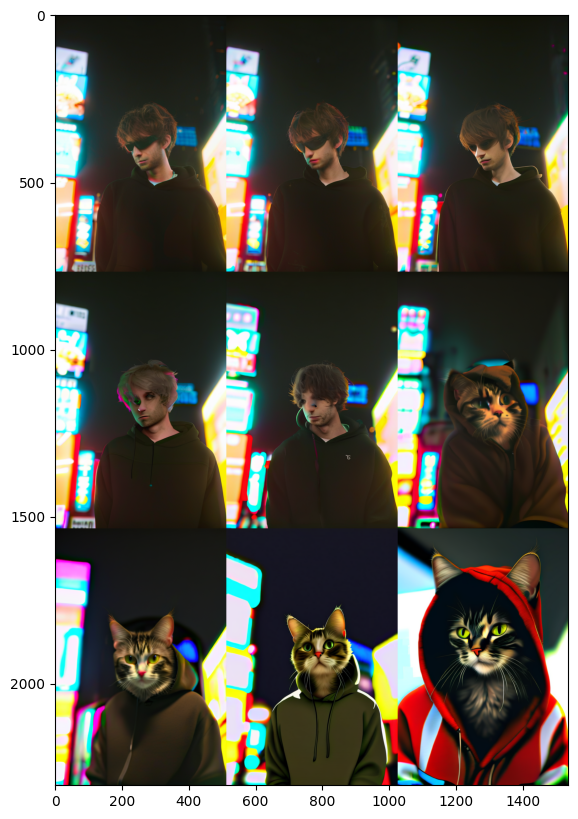

In [104]:
grid = image_grid(np.array(images), 3)
fig = plt.figure(figsize=(10., 10.))
plt.imshow(grid)

Diffusion модели это своя большая тема. И в каком-то смысле она сильно сложнее трансфоремеров - модели состоят из нескольких компонентов и пространств, есть всякие schedulers и разные типы распределений. Этот мем не преувеличение
![](https://i.ibb.co/jvT2S1Y/Screenshot-2024-05-16-at-15-03-34.png)

Если хотите разобраться немного подробнее, можете начать с вот [этой тетрадки](https://colab.research.google.com/github/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb#scrollTo=42d594a2-cc70-4daf-81eb-005e906118d3) 

И еще посмотреть вот [эти видео](https://www.youtube.com/watch?v=_7rMfsA24Ls) от fast.ai (они про первые версии stable diffusion, но основные моменты точно такие же)
